<h2>Hypertune XGBoost using randomizedsearchCV on avgW2V features with other features </h2>

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df_train = df.loc[:69999,:]
df_test = df.loc[70000:99999,:]

In [40]:
df_test.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
70000,70000,120726,120727,What are some cake ideas for a teenager?,What are some teenage cake ideas?,1,"[-0.4615742415189743, 5.592962011694908, -5.16...","[-1.6438209861516953, 2.9957278221845627, -5.0..."
70001,70001,120728,120729,Is there any encryption technique that cannot ...,How long does it take for a quantum computer t...,0,"[-9.322475790977478, 12.87209065258503, -7.112...","[1.2852164027281106, 12.787952169775963, -4.96..."
70002,70002,120730,120731,Could Napoleon have won the Napoleonic Wars?,How could Napoleon have won in Russia?,0,"[-7.683586522936821, 2.8382886052131653, 11.72...","[-7.846307143568993, 8.699695736169815, 4.4572..."
70003,70003,120732,120733,Is there an Airbnb for car-sharing in Canada?,Is there an Airbnb for car-sharing?,0,"[-0.028497308492660522, 8.290659457445145, -6....","[3.1676465570926666, 6.498601824045181, -5.305..."
70004,70004,31392,120734,Does blocking someone from Instagram cause the...,If someone blocks me on Instagram can they sti...,0,"[13.570038013160229, 20.701649758964777, -44.8...","[7.011820152401924, 18.275503396987915, -34.28..."


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 70000 to 99999
Data columns (total 6 columns):
id              30000 non-null int64
qid1            30000 non-null int64
qid2            30000 non-null int64
question1       30000 non-null object
question2       30000 non-null object
is_duplicate    30000 non-null int64
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_tr = list(df_train['question1']) + list(df_train['question2'])
questions_te = list(df_test['question1']) + list(df_test['question2'])


tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions_tr)

tfidf.transform(questions_te)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [12]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_vectors_web_lg')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_train['q1_feats_m'] = list(vecs1)


In [13]:
vecs2 = []
for qu2 in tqdm(list(df_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_train['q2_feats_m'] = list(vecs2)

In [14]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_test['q1_feats_m'] = list(vecs1)


In [15]:
vecs2 = []
for qu2 in tqdm(list(df_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_test['q2_feats_m'] = list(vecs2)

In [32]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [33]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df3_train = df_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_test = df_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df3_q1_train = pd.DataFrame(df3_train.q1_feats_m.values.tolist(), index= df3_train.index)
df3_q2_train = pd.DataFrame(df3_train.q2_feats_m.values.tolist(), index= df3_train.index)

df3_q1_test = pd.DataFrame(df3_test.q1_feats_m.values.tolist(), index= df3_test.index)
df3_q2_test = pd.DataFrame(df3_test.q2_feats_m.values.tolist(), index= df3_test.index)


In [41]:
df1_train = df1[:70000]
df1_test = df1[70000:100000]

df2_train = df2[:70000]
df2_test = df2[70000:100000]

In [35]:
df1_train.tail()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
69995,69995,1,0.999950,0.666644,0.749981,0.749981,0.833319,0.714276,0.0,1.0,1.0,6.5,96,84,88,93,0.580645
69996,69996,1,0.666644,0.499988,0.999975,0.799984,0.857131,0.666659,1.0,1.0,2.0,8.0,94,84,81,78,0.324324
69997,69997,0,0.333322,0.249994,0.799984,0.799984,0.624992,0.555549,0.0,1.0,1.0,8.5,78,68,76,76,0.565217
69998,69998,0,0.499988,0.399992,0.000000,0.000000,0.399992,0.249997,0.0,0.0,3.0,6.5,44,35,48,59,0.216216
69999,69999,1,0.749981,0.749981,0.999967,0.599988,0.857131,0.666659,0.0,1.0,2.0,8.0,92,78,83,84,0.545455


In [36]:
df1_test.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
70000,70000,1,0.666644,0.666644,0.999967,0.599988,0.833319,0.624992,0.0,1.0,2.0,7.0,90,90,68,76,0.411765
70001,70001,0,0.399992,0.249997,0.000000,0.000000,0.153845,0.133332,0.0,0.0,2.0,14.0,59,59,30,43,0.220779
70002,70002,0,0.666644,0.499988,0.666644,0.499988,0.571420,0.571420,0.0,0.0,0.0,7.0,77,70,65,66,0.615385
70003,70003,0,0.999967,0.749981,0.999975,0.799984,0.999986,0.777769,0.0,1.0,2.0,8.0,100,87,87,100,0.972222
70004,70004,0,0.249997,0.249997,0.142855,0.083333,0.187499,0.124999,0.0,0.0,8.0,20.0,52,45,43,46,0.122642


In [31]:
df3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
id            70000 non-null int64
q1_feats_m    70000 non-null object
q2_feats_m    70000 non-null object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [18]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [45]:
# data before preprocessing 
df3_q1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 160.2 MB


In [20]:
# Questions 1 tfidf weighted word2vec
df3_q1_train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-5.678341,17.530854,4.767729,8.021592,20.284790,-5.498321,-4.154142,-2.753028,8.035586,146.820392,...,-17.296842,5.405489,0.447179,-8.398855,-1.906411,-10.775995,-13.011710,3.356182,1.184709,16.789048
1,8.467263,13.023918,18.441372,-2.253075,-14.933545,-1.905144,9.034039,-19.527934,-20.590989,16.727846,...,24.319270,1.361967,-9.898601,5.905469,29.164173,3.705868,-28.096061,11.905772,-7.571094,30.854839
2,1.013088,16.138956,-8.150289,-4.897168,-2.783187,9.813789,4.432029,-5.168837,6.834084,106.687464,...,-21.057970,2.404339,8.692217,-0.670134,16.342391,-2.727455,10.608536,-1.088184,-7.383166,19.400510
3,-4.963022,17.058119,-15.398349,1.018699,-2.385775,-0.009750,2.653501,-8.421146,2.516107,115.509200,...,-2.582448,-4.883153,-0.462400,-1.942324,9.304168,2.510558,4.764632,-1.218335,-2.840903,3.268202
4,-11.125062,19.905821,-4.093182,-6.196883,-20.805312,32.305036,-30.900851,1.034236,-18.629877,84.868632,...,-8.765291,-5.057371,18.897644,-39.186044,-11.491373,16.013101,-0.691998,-10.030701,-7.658805,23.307218


In [22]:
# Questions 2 tfidf weighted word2vec
df3_q2_test.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
70000,-1.643821,2.995728,-5.013487,-2.060495,-4.748236,-0.059067,0.270084,-0.296805,7.277772,74.438575,...,-7.741593,2.559344,2.473485,5.224206,1.262848,-0.200858,-0.114223,-8.311147,-1.291231,11.202477
70001,1.285216,12.787952,-4.969135,0.150222,-3.255234,2.345234,-5.966830,-10.950854,17.399258,100.461091,...,-14.123961,-1.360150,1.909143,5.457284,14.133374,-0.290380,12.521746,10.041966,6.579004,10.977388
70002,-7.846307,8.699696,4.457276,-4.747743,-0.247509,-6.322785,2.589292,-5.029269,6.655110,60.201506,...,3.280515,7.250862,0.633417,-4.662525,6.930059,4.226840,4.836946,-0.071511,10.726589,5.850212
70003,3.167647,6.498602,-5.305903,4.210617,-4.383907,2.274286,5.446064,-10.008556,5.603269,63.488409,...,-10.448545,-2.950056,4.594756,-3.209882,0.214583,-2.831094,-2.406799,3.791670,-3.150036,9.444092
70004,7.011820,18.275503,-34.282401,-0.149382,6.029610,-0.932729,-8.865124,-11.803554,-4.607860,258.660846,...,-26.967697,0.102033,8.013830,16.572992,14.287454,-7.044630,-13.224762,-14.174832,13.657328,21.714777


In [46]:
df3_q1_train['id'] = df1_train['id']
df3_q2_train['id'] = df1_train['id']

df3_q1_test['id'] = df1_test['id']
df3_q2_test['id'] = df2_test['id']


df1_train = df1_train.merge(df2_train , on = 'id' , how = 'left')
df2_train = df3_q1_train.merge(df3_q2_train , on= 'id', how = 'left')
train_data = df1_train.merge(df2_train, on= 'id', how='left')


df1_test = df1_test.merge(df2_test , on = 'id' , how = 'left')
df2_test = df3_q1_test.merge(df3_q2_test , on= 'id', how = 'left')
test_data = df1_test.merge(df2_test, on= 'id', how='left')

In [48]:
train_data.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,-17.722322,7.210848,1.560627,-7.553982,0.413443,-11.831222,-11.320478,2.014848,3.508343,12.031769
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,21.603077,3.816482,-4.637692,6.751429,32.837261,6.008906,-26.927030,12.199380,-4.311462,32.635382
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,-24.362199,-1.257603,11.921908,9.668108,11.891763,1.331647,6.606182,-0.184381,-12.663971,27.797133
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,-5.391686,1.662087,-0.781292,-2.849823,-3.527011,-3.707292,-4.192988,-12.482117,4.452041,-6.207533
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,-10.436148,-8.375029,-14.418071,-12.666133,-4.445768,12.530975,-11.736673,-16.401188,3.687729,-9.810974


In [50]:
test_data.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,70000,1,0.666644,0.666644,0.999967,0.599988,0.833319,0.624992,0.0,1.0,...,-7.741593,2.559344,2.473485,5.224206,1.262848,-0.200858,-0.114223,-8.311147,-1.291231,11.202477
1,70001,0,0.399992,0.249997,0.000000,0.000000,0.153845,0.133332,0.0,0.0,...,-14.123961,-1.360150,1.909143,5.457284,14.133374,-0.290380,12.521746,10.041966,6.579004,10.977388
2,70002,0,0.666644,0.499988,0.666644,0.499988,0.571420,0.571420,0.0,0.0,...,3.280515,7.250862,0.633417,-4.662525,6.930059,4.226840,4.836946,-0.071511,10.726589,5.850212
3,70003,0,0.999967,0.749981,0.999975,0.799984,0.999986,0.777769,0.0,1.0,...,-10.448545,-2.950056,4.594756,-3.209882,0.214583,-2.831094,-2.406799,3.791670,-3.150036,9.444092
4,70004,0,0.249997,0.249997,0.142855,0.083333,0.187499,0.124999,0.0,0.0,...,-26.967697,0.102033,8.013830,16.572992,14.287454,-7.044630,-13.224762,-14.174832,13.657328,21.714777


In [52]:
train_data.to_csv('final_jun24_train.csv', sep=';')
test_data.to_csv('final_jun24_test.csv', sep=';')


In [55]:
y_train = train_data['is_duplicate']
train_data = train_data.drop(['id', 'is_duplicate'],axis=1)
X_train = train_data.iloc[:,:].values


y_test = test_data['is_duplicate']
test_data = test_data.drop(['id', 'is_duplicate'],axis=1)
X_test = test_data.iloc[:,:].values


In [56]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((70000, 626), (70000,), (30000, 626), (30000,))

In [58]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6275428571428572 Class 1:  0.3724571428571429
---------- Distribution of output variable in train data ----------
Class 0:  0.37273333333333336 Class 1:  0.37273333333333336


In [59]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8816597149250973


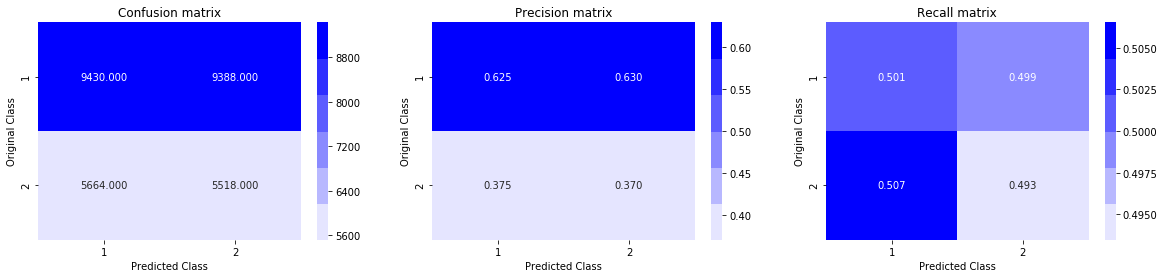

In [62]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [63]:
from xgboost import XGBClassifier as xgbc
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats



clf = xgbc(objective = 'binary:logistic',eval_metric = 'logloss',  early_stopping_rounds= 10)

tuned_param = {

        'max_depth': [3,4,5],
        'learning_rate': stats.uniform(0.01,0.15),       
        'n_estimators': [x for x in range(61,101,10) ]
    
        }


model = RandomizedSearchCV(clf, tuned_param, n_iter=15, verbose=15, cv=2,random_state=42)

model.fit(X_train , y_train)

print(model.best_estimator_)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV] learning_rate=0.06618101782710437, max_depth=3, n_estimators=81 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.06618101782710437, max_depth=3, n_estimators=81, score=0.8107428571428571, total= 2.3min
[CV] learning_rate=0.06618101782710437, max_depth=3, n_estimators=81 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV]  learning_rate=0.06618101782710437, max_depth=3, n_estimators=81, score=0.8082, total= 2.5min
[CV] learning_rate=0.11979909127171076, max_depth=3, n_estimators=61 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s


[CV]  learning_rate=0.11979909127171076, max_depth=3, n_estimators=61, score=0.8156571428571429, total= 2.1min
[CV] learning_rate=0.11979909127171076, max_depth=3, n_estimators=61 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.9min remaining:    0.0s


[CV]  learning_rate=0.11979909127171076, max_depth=3, n_estimators=61, score=0.8122571428571429, total= 2.0min
[CV] learning_rate=0.033402796066365474, max_depth=5, n_estimators=81 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.9min remaining:    0.0s


[CV]  learning_rate=0.033402796066365474, max_depth=5, n_estimators=81, score=0.8159714285714286, total= 4.0min
[CV] learning_rate=0.033402796066365474, max_depth=5, n_estimators=81 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.9min remaining:    0.0s


[CV]  learning_rate=0.033402796066365474, max_depth=5, n_estimators=81, score=0.8134, total= 3.9min
[CV] learning_rate=0.01871254182522992, max_depth=3, n_estimators=91 .


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.9min remaining:    0.0s


[CV]  learning_rate=0.01871254182522992, max_depth=3, n_estimators=91, score=0.7947142857142857, total= 2.6min
[CV] learning_rate=0.01871254182522992, max_depth=3, n_estimators=91 .


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 19.5min remaining:    0.0s


[CV]  learning_rate=0.01871254182522992, max_depth=3, n_estimators=91, score=0.7928, total= 2.7min
[CV] learning_rate=0.031430022688291114, max_depth=5, n_estimators=71 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 22.1min remaining:    0.0s


[CV]  learning_rate=0.031430022688291114, max_depth=5, n_estimators=71, score=0.8153428571428571, total= 3.5min
[CV] learning_rate=0.031430022688291114, max_depth=5, n_estimators=71 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 25.7min remaining:    0.0s


[CV]  learning_rate=0.031430022688291114, max_depth=5, n_estimators=71, score=0.8111714285714285, total= 3.5min
[CV] learning_rate=0.01846173685406504, max_depth=4, n_estimators=71 .


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 29.2min remaining:    0.0s


[CV]  learning_rate=0.01846173685406504, max_depth=4, n_estimators=71, score=0.8013142857142858, total= 2.7min
[CV] learning_rate=0.01846173685406504, max_depth=4, n_estimators=71 .


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 31.9min remaining:    0.0s


[CV]  learning_rate=0.01846173685406504, max_depth=4, n_estimators=71, score=0.7993142857142858, total= 2.9min
[CV] learning_rate=0.010116814876152149, max_depth=3, n_estimators=61 


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 34.8min remaining:    0.0s


[CV]  learning_rate=0.010116814876152149, max_depth=3, n_estimators=61, score=0.7883428571428571, total= 1.8min
[CV] learning_rate=0.010116814876152149, max_depth=3, n_estimators=61 


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 36.6min remaining:    0.0s


[CV]  learning_rate=0.010116814876152149, max_depth=3, n_estimators=61, score=0.7832, total= 1.8min
[CV] learning_rate=0.05563633644393066, max_depth=4, n_estimators=61 .


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 38.5min remaining:    0.0s


[CV]  learning_rate=0.05563633644393066, max_depth=4, n_estimators=61, score=0.8133142857142858, total= 2.4min
[CV] learning_rate=0.05563633644393066, max_depth=4, n_estimators=61 .
[CV]  learning_rate=0.05563633644393066, max_depth=4, n_estimators=61, score=0.8095142857142857, total= 2.4min
[CV] learning_rate=0.07479175279631736, max_depth=3, n_estimators=81 .
[CV]  learning_rate=0.07479175279631736, max_depth=3, n_estimators=81, score=0.8136, total= 2.4min
[CV] learning_rate=0.07479175279631736, max_depth=3, n_estimators=81 .
[CV]  learning_rate=0.07479175279631736, max_depth=3, n_estimators=81, score=0.8098285714285715, total= 2.8min
[CV] learning_rate=0.10177793420835692, max_depth=4, n_estimators=91 .
[CV]  learning_rate=0.10177793420835692, max_depth=4, n_estimators=91, score=0.8268285714285715, total= 3.9min
[CV] learning_rate=0.10177793420835692, max_depth=4, n_estimators=91 .
[CV]  learning_rate=0.10177793420835692, max_depth=4, n_estimators=91, score=0.8224285714285714, total

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 89.1min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=10, eval_metric='logloss',
       gamma=0, learning_rate=0.13899106101044809, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=61,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [64]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=10, eval_metric='logloss',
       gamma=0, learning_rate=0.13899106101044809, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=61,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [68]:
xgb_best = model.best_estimator_

xgb_best.fit(X_train, y_train)

predict_y = xgb_best.predict_proba(X_test)

print("The test log loss is:",log_loss(y_test, predict_y, labels = [0,1], eps=1e-15))

The test log loss is: 0.34815545727438585


In [66]:
predict_y = xgb_best.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels = [0,1], eps=1e-15))

The train log loss is: 0.3209566132494947


Total number of data points : 30000


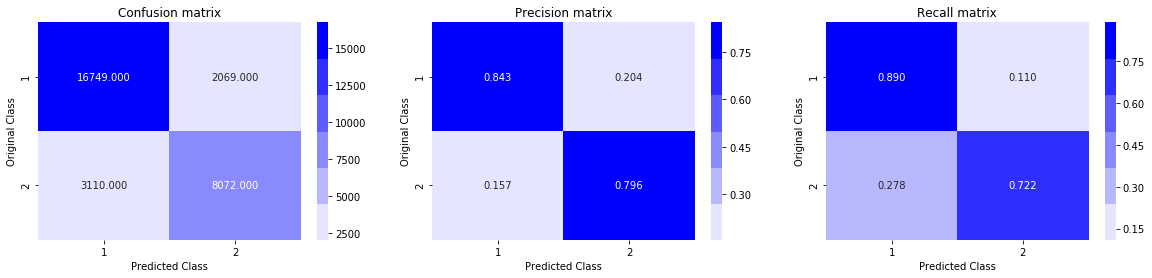

In [82]:
# predicted_y =np.array(predict_y[0] >0.5,dtype=int)
predicted_y = []

for pre in predict_y[:,0]:
    if pre > 0.5:
        predicted_y.append(0)
    else:
        predicted_y.append(1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [83]:
from prettytable import PrettyTable
summ = PrettyTable()

column_names = ["Parameter", "Logistic_reg", "L-SVM", "XGBoost"]
summ.add_column(column_names[0],['hyperparameter' , 'featurization', 'train_loss', 'test_loss'] )
summ.add_column(column_names[1], ['0.001','tfidf', '0.3974', '0.4114'])
summ.add_column(column_names[2],['0.001','tfidf', '0.4159', '0.4193'] )
summ.add_column(column_names[3],['LR=0.138,max_depth=5,n_estimators=61,','avgW2V', '0.348', '0.320'] )

print(summ)

+----------------+--------------+--------+---------------------------------------+
|   Parameter    | Logistic_reg | L-SVM  |                XGBoost                |
+----------------+--------------+--------+---------------------------------------+
| hyperparameter |    0.001     | 0.001  | LR=0.138,max_depth=5,n_estimators=61, |
| featurization  |    tfidf     | tfidf  |                 avgW2V                |
|   train_loss   |    0.3974    | 0.4159 |                 0.348                 |
|   test_loss    |    0.4114    | 0.4193 |                 0.320                 |
+----------------+--------------+--------+---------------------------------------+
